In [1]:
include("../src/RandomMatrixDistributions.jl")
using .RandomMatrixDistributions

In [2]:
using LinearAlgebra
using Distributions
using Plots

# Jacobi matrix sampler

## ESD of a single matrix
We compare the eigenvalue spectrum of a matrix *EH<sup>-1</sup>* to the Wachter distribution, which is its expected limiting empirical distribution.

To do this, we notice that if $\lambda$ is an eigenvalue of *(E+H)<sup>-1</sup>E*, then $\lambda/(1 - \lambda)$ is an eigenvalue of *EH<sup>-1</sup>*.

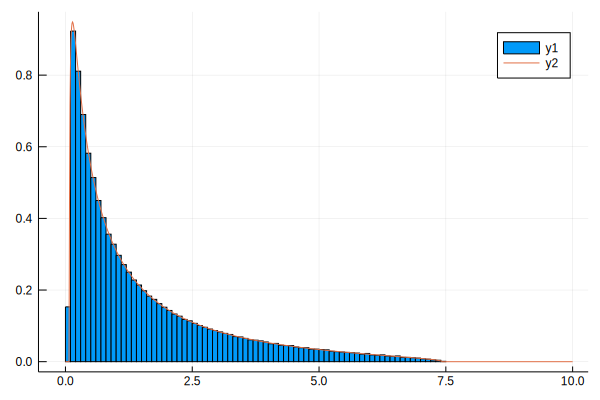

In [3]:
p = 10000
n1 = 20000
n2 = 30000

betaspectrum = randeigvals(Jacobi(1, n1, n2, p));

Fspectrum = [x/(1-x) for x in betaspectrum] * n2/n1

histogram(Fspectrum, bins = 100, normed=true)
plot!(x -> pdf(Wachter(p/n1, p/n2), x), 0:0.01:10)

## Max eigenvalue calculations

Johnstone (2004) gives a scaling for the maximum eigenvalue of a certain transformation of a Jacobi matrix to converge to a Tracy-Widom distribution.
We verify this in the following cell:

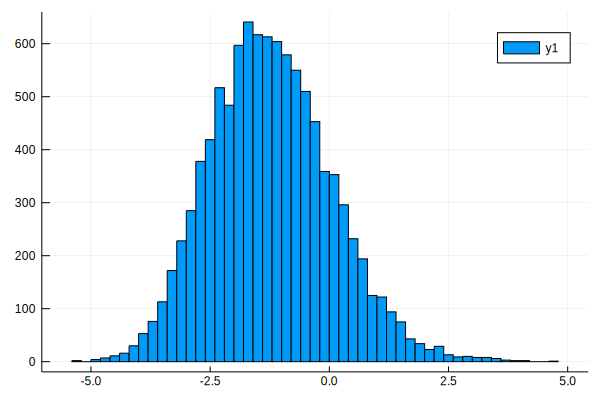

In [4]:
n1 = 1500
n2 = 1000
p = 500

γ = 2*asin(sqrt((p-1/2)/(n1 + n2 - 1)))
ϕ = 2*asin(sqrt((n1-1/2)/(n1 + n2 - 1)))

μ = 2*log(tan((γ + ϕ)/2))
σ = (16/((sin(γ) * sin(ϕ) * sin(γ + ϕ)^2)*(n1 + n2 - 1)^2))^(1/3)

λmax = randeigstat(Jacobi(1, n1, n2, p), eigmax, 10000)

logit(x) = log(x/(1-x))
λmaxstd = (logit.(λmax) .- μ)/σ

histogram(λmaxstd)

# Spiked Wishart sampler

In the following, we observe the expected behaviour of the ESD of a spiked Wishart matrix, comprising a Marchenko-Pastur bulk together with biased outliers.
We overlay the MP law over the bulk as well as the limiting normal densities for each sample eigenvalue spike.

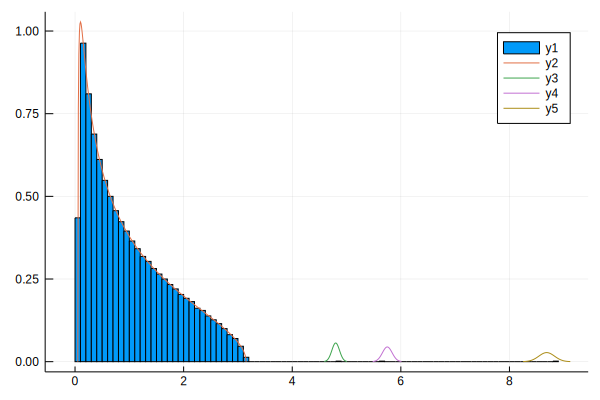

In [5]:
n = 10000
p = 6000

spikes = [3, 4, 7]
l = 1 .+ spikes
gamma = p/n
μspike = @. l * (1 + gamma/spikes)
σspike = @. l * sqrt(2 * (1 - gamma/spikes^2))

plt = histogram(randeigvals(SpikedWishart(1, n, p, spikes))/n, bins = 100, normed=true)

lsd = MarchenkoPastur(p/n)
plot!(plt, x -> pdf(lsd, x), minimum(lsd):0.01:(maximum(lsd) + 0.01))
for i in 1:length(spikes)
    plot!(plt, x -> pdf(Normal(μspike[i], σspike[i]/sqrt(p)), x)/100, (μspike[i] - σspike[i]*3/sqrt(p)):0.01:maximum(μspike[i] + σspike[i]*3/sqrt(p)))
end
display(plt)

We perform a stress test on the runtime, simulating the maximum eigenvalue of a spiked covariance with n = 10000, p = 6000 a total of 10000 times. Since the maximum eigenvalue is supercritical, we observe a limiting normal distribution as predicted by the theory.

239.990036 seconds (496.94 M allocations: 30.426 GiB, 3.02% gc time)


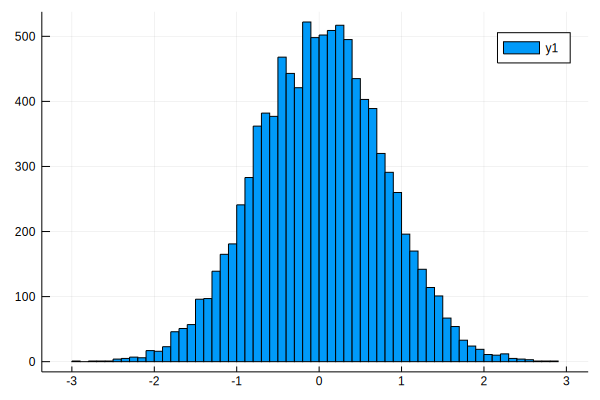

In [6]:
@time λmax = randeigstat(SpikedWishart(1, n, p, spikes), eigmax, 10000)/n
histogram(sqrt(p) * (λmax .- μspike[end])/σspike[end])

We repeat a maximum eigenvalue simulation for an unspiked covariance with more modest observation and parameter numbers to once again recover the expected Tracy-Widom curve.

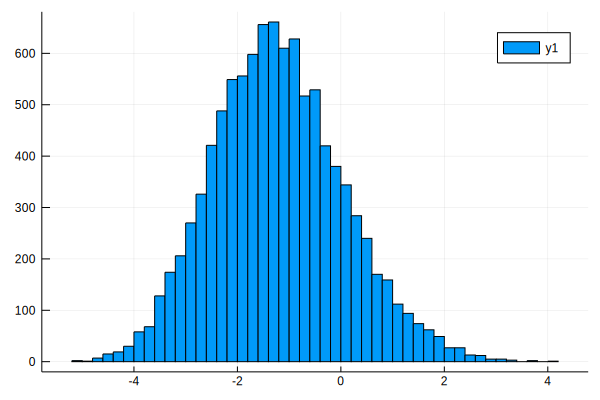

In [7]:
n = 1000
p = 400

# Scaling from Johnstone 2001
μTW = (√(n-1) + √(p))^2
σTW = (√(n-1) + √(p))*(1/√(n-1) + 1/√(p))^(1/3)

λmax = randeigstat(SpikedWishart(1, n, p), eigmax, 10000)
λmaxstd = (λmax .- μTW)/σTW

histogram(λmaxstd)